In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import tensorflow as tf
import math

In [2]:
# %load nn17_ex3_main.py
#!/usr/bin/env python3

# Import Data

# plt.close('all')  # if you like

# load dataset

with open('isolet_crop_train.pkl', 'rb') as f:
    train_data = pkl.load(f)

with open('isolet_crop_test.pkl', 'rb') as f:
    test_data = pkl.load(f)

X_train, y_train = train_data
X_test, y_test = test_data

y_train = y_train - 1 
y_test = y_test - 1  

# normalize the data and check the results

# ...

#print(X_train.mean(axis=0))
#print(X_train.var(axis=0))

# split the data sets, etc.

# ...

In [3]:
# Get training Data statistics

# Number of Training examples
n_train = len(X_train)
# Number of Testing examples
n_test = len(X_test)
# Number of Training features
n_TrainFeatures = len(X_train[0])
# Number of Testing features (should be equal to that of training)
n_TestFeatures = len (X_test[0])
# Number of Training classes
n_TrainClasses =  len(np.unique(y_train))
# Number of Testing Classes (should be equal to that of training)
n_TestClasses = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("....")
print("Number of Training features =", n_TrainFeatures)
print("Number of Testing features =", n_TestFeatures)
print("....")
print("Number of Training Classes =", n_TrainClasses)
print("Number of Testing Classes =", n_TestClasses)

Number of training examples = 6238
Number of testing examples = 1559
....
Number of Training features = 300
Number of Testing features = 300
....
Number of Training Classes = 26
Number of Testing Classes = 26


##  a) Make yourself familiar with the dataset. Normalize each feature to zero mean and unitvariance.

In [4]:
#X_train, y_train = train_data
#X_test, y_test = test_data

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

# Training data normalization
X_train = (X_train - X_mean) / X_std

# Testing data normalization
X_test = (X_test - X_mean) / X_std

# Split Data

In [5]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)

from sklearn.model_selection import train_test_split
# First split in 70% -- 30%
X_train2, X_temp, y_train2, y_temp  = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#Split the 30% into half to get 15% -- 15% (from X_train)for validation and early stop
X_validation, X_stop, y_validation, y_stop = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

n_input = len(X_train2)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_train2.shape)
print(y_train2.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_stop.shape)
print(y_stop.shape)

(6238, 300)
(6238,)
(4366, 300)
(4366,)
(936, 300)
(936,)
(936, 300)
(936,)


## one-out-of-K coding

tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 300))
y = tf.placeholder(tf.int32,(None))
one_hot_y = tf.one_hot(y, 26)


# Network

In [7]:

def Train_Classifier(x, Layers = [20,26],activation = tf.sigmoid):
    
    #print("In Traffic Sign Classifier.......................................................................... \n")
   
    #M = x.shape[1] #300
    M = x.get_shape().as_list()[1]
    M = float(M)
    C = Layers[-1] #26
    n_layers = len(Layers)
    Layers = np.insert(Layers,0,M)
    W = []
    b = []
    a = []
    z = []
    min_d = 1./math.sqrt(300)
    for i in range(n_layers):
        W.append(tf.Variable(tf.random_uniform([Layers[i], Layers[i+1]],-min_d,min_d),name='weights_{}'.format(i)))
        b.append(tf.Variable(tf.zeros(Layers[i+1]),name='bias_{}'.format(i)))
        if i == 0:
            a.append(tf.add(tf.matmul(x,W[i]),b[i]))
        else:
            a.append(tf.add(tf.matmul(z[i-1],W[i]),b[i]))
        z.append(activation(a[i]))
    logits =  a[-1]
    
    return logits

In [8]:
def evaluate(X_data, y_data,accuracy_operation):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
    

In [9]:
def network(logits,opt,rate):
    rate = 0.1 # learning rate

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = opt(learning_rate=rate)
    training_operation = optimizer.minimize(loss_operation)   
    
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    #saver =tf.train.Saver()
    #print("Initialized")
    return training_operation,accuracy_operation

In [10]:
def train(logits, opt, rate,stop_on_convergence = True,ret = 'model'):
    save_file = './modelTest1.ckpt'
    
    
    #np.array(train_acc_list)
    
    #with tf.Session() as sess:
    training_operation,accuracy_operation = network(logits,opt,rate)
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train2)

    TempValidat_acc_list = []
    TempTrain_acc_list = []
    TempEarlyStopping_acc_list = []

    validat_acc_list = []
    train_acc_list = []
    earlyStoping_acc_list = []

    earlyStoppingMax = -1
    val_for_best_model = -1

    #logits = (Train_Classifier(x,[20,C], Algo[j]))
    #network(logits)
    for i in range(EPOCHS):
         
        X_train21, y_train21 = shuffle(X_train2,y_train2)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train21[offset:end], y_train21[offset:end]
            #logits = Logits[j]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            #print(logits)

        validation_accuracy = evaluate(X_validation, y_validation,accuracy_operation)
        training_accuracy = evaluate(X_train2, y_train2,accuracy_operation)
        earlyStoping_accuracy = evaluate(X_stop,y_stop,accuracy_operation)

        if earlyStoppingMax < earlyStoping_accuracy:
            earlyStoppingMax = earlyStoping_accuracy
            val_for_best_model = validation_accuracy
            #print('Best so far = {} on iteration {}'.format(earlyStoppingMax,i))
            #saver.save(sess,save_file)
            #print(sess.run(tempw))

        
        TempValidat_acc_list.append(validation_accuracy)
        TempTrain_acc_list.append(training_accuracy)
        TempEarlyStopping_acc_list.append(earlyStoping_accuracy)



        if i%STEP_SIZE == 0:
            validat_acc_list.append(np.mean(TempValidat_acc_list))
            TempValidat_acc_list = []

            train_acc_list.append(np.mean(TempTrain_acc_list))
            TempTrain_acc_list = []           

            earlyStoping_acc_list.append(np.mean(TempEarlyStopping_acc_list))
            TempEarlyStopping_acc_list = []  
            #print("EPOCH {} ...".format(i+1))
            #print("Validation Accuracy = {:.3f}".format(validat_acc_list[-1]))
            if stop_on_convergence and len(validat_acc_list) > 1:
                if validat_acc_list[-1] < validat_acc_list[-2] - 1e-3:
                    print("#############STOP################")
                    break
        ## end for
    #print(earlyStoppingMax)
    if ret == 'plots':
        return train_acc_list,validat_acc_list,earlyStoping_acc_list
    elif ret == 'error':
        return 1-val_for_best_model
    elif ret == 'model':
        return 0 # TODO
    #return earlyStoppingMax
    #Valid_acc_lists[j] = validat_acc_list
    #Train_acc_lists[j] = train_acc_list
    #EarlyStopping_acc_lists[j] = earlyStoping_acc_list
        





In [11]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 300))
y = tf.placeholder(tf.int32,(None))
one_hot_y = tf.one_hot(y, 26)

In [12]:
EPOCHS = 300
BATCH_SIZE = 40
INDP_RUNS = 5
STEP_SIZE = 10

def try_comb(classifier,optimizer, rate):
    err = 0
    for i in range(INDP_RUNS):
        err += train(classifier,optimizer,rate)
    return err / INDP_RUNS

with tf.Session() as sess:
    result = try_comb(Train_Classifier(x) , tf.train.RMSPropOptimizer,0.005)
    print(result)

In [13]:
def try_comb(classifier,optimizer, rate):
    train_list, val_list, es_list = train(classifier,optimizer,rate,stop_on_convergence = False,ret = 'plots')
    train_list = np.array(train_list)
    val_list = np.array(val_list)
    es_list = np.array(es_list)
    for i in range(INDP_RUNS-1):
        tr, va, es = train(classifier,optimizer,rate,stop_on_convergence = False,ret = 'plots')
        train_list = train_list + np.array(tr)
        val_list =val_list + np.array(va)
        es_list = es_list + np.array(es)
    return np.divide(train_list,INDP_RUNS),np.divide(val_list,INDP_RUNS),np.divide(es_list,INDP_RUNS)

### Now we compare the rates for each optimizing algorithm and choose the best ones
#### The architecture is fixed for comparison which is one hidden layer with the same number of neurons and the number of epochs is fixed too

In [ ]:
sgd_rates = np.array([0.01,0.05,0.1,0.5,1])
#x_axis = np.linspace(0,EPOCHS,10)
for rate in sgd_rates:
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26]) , tf.train.GradientDescentOptimizer,rate)
        plt.figure
        
        plt.plot(tr,'r--')
        plt.plot(va,'b--')
        plt.plot(es,'g')
        plt.show()
        print('Accuracy of rate {} = {}, es = {}'.format(rate,va[np.argmax(es)],np.max(es)))

#### Based on the comparison, we see that $rate = 0.05$ is the best choice for SGD

In [ ]:
rms_rates = np.array([0.001,0.005,0.008,0.01,0.05,0.1])
for rate in rms_rates:
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26]) , tf.train.RMSPropOptimizer,rate)
        plt.figure
        plt.plot(tr,'r--')
        plt.plot(va,'b--')
        plt.plot(es,'g')
        plt.show()
        print('Accuracy of rate {} = {}, es = {}'.format(rate,va[np.argmax(es)],np.max(es)))

#### Based on the comparison, we see that $rate = 0.1$ is the best choice for RMS prop

In [ ]:
adam_rates = np.array([0.001,0.005,0.008,0.01,0.05,0.1])
for rate in adam_rates:
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26]) , tf.train.AdamOptimizer,rate)
        plt.figure
        plt.plot(tr,'r--')
        plt.plot(va,'b--')
        plt.plot(es,'g')
        plt.show()
        print('Accuracy of rate {} = {}, es = {}'.format(rate,va[np.argmax(es)],np.max(es)))

#### Based on the comparison, we see that $rate = 0.01$ is the best choice for ADAM

### Now comparing the three algorithms with their best learning rates, we see that standard stochastic gradient descent with learning rate 0.05 has the best performance.

In [45]:
chosen_rate = 0.05;
chosen_opt = tf.train.GradientDescentOptimizer

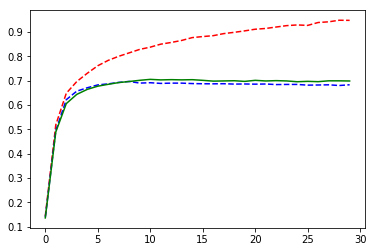

Accuracy with activation Sigmoid with opt: 'SGD' = 0.6919337606837608, es = 0.7057158124243093


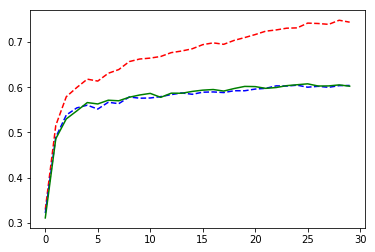

Accuracy with activation Sigmoid with opt: 'RMS' = 0.6002670941317184, es = 0.6077457256296761


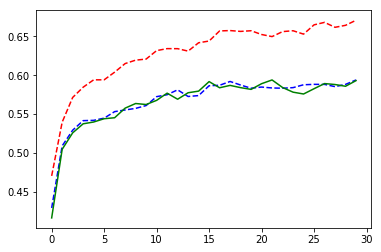

Accuracy with activation Sigmoid with opt: 'ADAM' = 0.5836538471345207, es = 0.5939636743476249


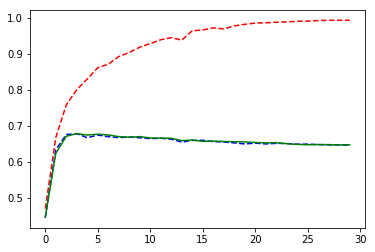

Accuracy with activation Tan_h with opt: 'SGD' = 0.6778311956132579, es = 0.678418804374006


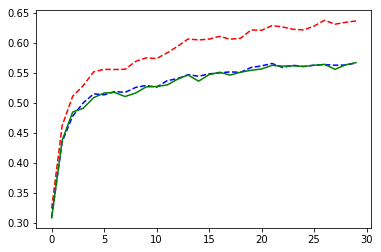

Accuracy with activation Tan_h with opt: 'RMS' = 0.5667200835851522, es = 0.5672542723325582


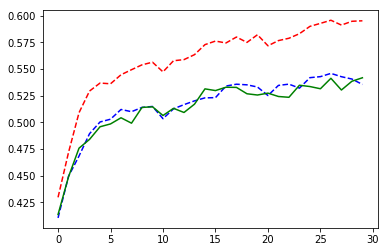

Accuracy with activation Tan_h with opt: 'ADAM' = 0.5355769212174619, es = 0.541826919791026


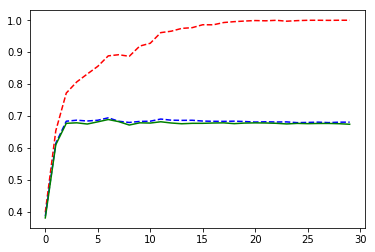

Accuracy with activation ReLU with opt: 'SGD' = 0.6945512815927848, es = 0.6892094010471279


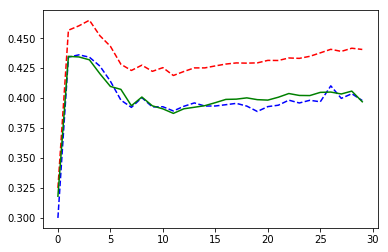

Accuracy with activation ReLU with opt: 'RMS' = 0.4341880332710396, es = 0.4348290577849262


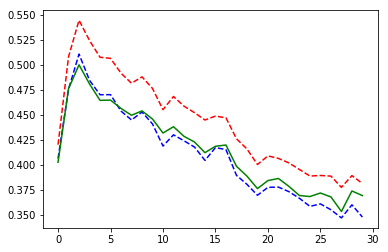

Accuracy with activation ReLU with opt: 'ADAM' = 0.5109508524465765, es = 0.5002136721315547


In [61]:
Algo = [tf.sigmoid, tf.tanh,tf.nn.relu]
names = ['Sigmoid', 'Tan_h', 'ReLU']
Opt = [tf.train.GradientDescentOptimizer,tf.train.RMSPropOptimizer, tf.train.AdamOptimizer]
rates = [0.05, 0.1, 0.01]

Opt_name = ['SGD','RMS','ADAM']
for i in range(len(Algo)):
    activation = Algo[i]
    for j in range(len(Opt)):
        with tf.Session() as sess:
            tr,va,es = try_comb(Train_Classifier(x,[20,26],activation) ,Opt[j], rates[j])
            plt.figure
            plt.plot(tr,'r--')
            plt.plot(va,'b--')
            plt.plot(es,'g')
            plt.show()
            print('Accuracy with activation {} with opt: \'{}\' = {}, es = {}'.format(names[i],Opt_name[j],va[np.argmax(es)],np.max(es)))

### The best activation function is this combination was SGD with ReLU (Learning rate = 0.05 )

## ToDO 

In [14]:
chosen_opt = tf.train.GradientDescentOptimizer
chosen_rate = 0.05
chosen_activation = tf.nn.relu

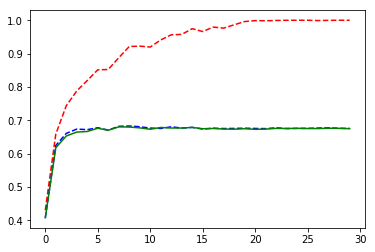

Accuracy with hidden layers is:0 and neurons/layer: 20  = 0.6820512835541344, es = 0.6803952996165324


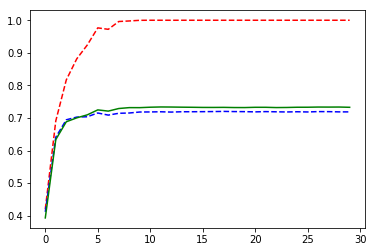

Accuracy with hidden layers is:0 and neurons/layer: 50  = 0.719017091826496, es = 0.7337606837352116


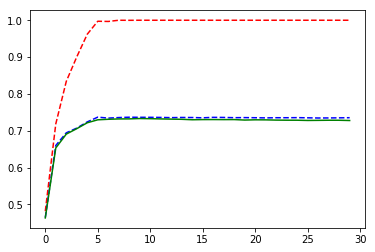

Accuracy with hidden layers is:0 and neurons/layer: 100  = 0.7363782056376464, es = 0.733066238857742


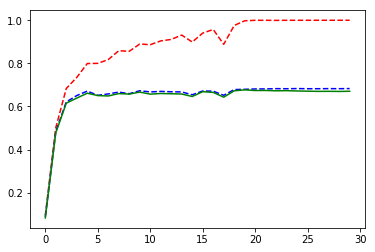

Accuracy with hidden layers is:1 and neurons/layer: 20  = 0.6794871773475255, es = 0.6770299147846353


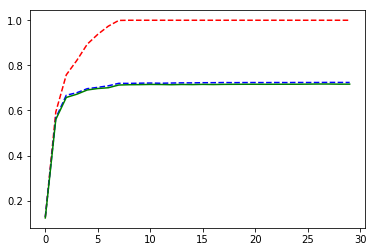

Accuracy with hidden layers is:1 and neurons/layer: 50  = 0.7239850415633275, es = 0.7171474348785531


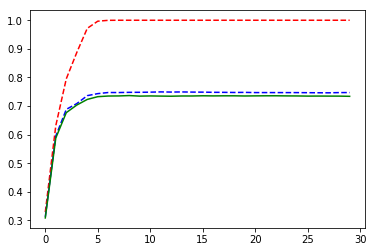

Accuracy with hidden layers is:1 and neurons/layer: 100  = 0.7478632505378153, es = 0.7365918800107434


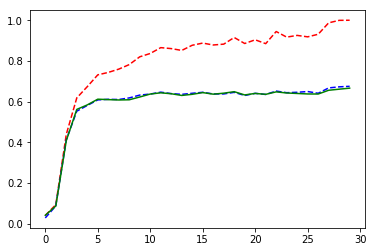

Accuracy with hidden layers is:2 and neurons/layer: 20  = 0.6750534168420694, es = 0.6659722219420294


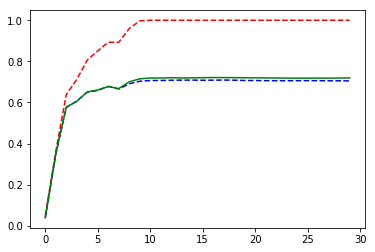

Accuracy with hidden layers is:2 and neurons/layer: 50  = 0.7082799124157327, es = 0.7211538429698374


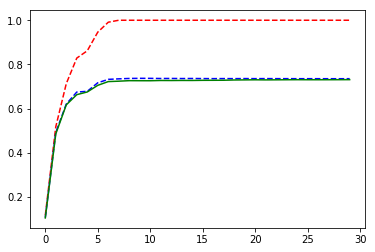

Accuracy with hidden layers is:2 and neurons/layer: 100  = 0.7356303391548303, es = 0.7312500006877459


In [79]:
for hidden_layers in range(3):
    for neurons in [20,50,100]:
        layers = np.full(hidden_layers+1,neurons)
        layers = np.append(layers,26)
        with tf.Session() as sess:
            tr,va,es = try_comb(Train_Classifier(x,layers,chosen_activation) ,chosen_opt,chosen_rate)
            plt.figure
            plt.plot(tr,'r--')
            plt.plot(va,'b--')
            plt.plot(es,'g')
            plt.show()
            print('Accuracy with hidden layers is:{} and neurons/layer: {}  = {}, es = {}'.format(hidden_layers,neurons,va[np.argmax(es)],np.max(es)))


In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)

from sklearn.model_selection import train_test_split
# First split in 70% -- 30%
X_train2, X_temp, y_train2, y_temp  = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#Split the 30% into half to get 15% -- 15% (from X_train)for validation and early stop
X_validation, X_stop, y_validation, y_stop = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

n_input = len(X_train2)

In [15]:
X_train2 = np.concatenate((X_train2, X_validation),axis = 0)
y_train2 = np.concatenate((y_train2, y_validation),axis = 0)
X_validation = X_stop
y_validation = y_stop

X_stop = X_test
y_stop = y_test

In [16]:
print(X_train2.shape)
print(y_train2.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_stop.shape)
print(y_stop.shape)

(5302, 300)
(5302,)
(936, 300)
(936,)
(1559, 300)
(1559,)


In [27]:
def try_on_test(classifier,optimizer, rate):
    err = 0
    for i in range(INDP_RUNS):
        tr,te,es= train(classifier,optimizer,rate,stop_on_convergence=True,ret ='plots')
        plt.figure
        plt.plot(tr,'r--')
        plt.plot(te,'b--')
        plt.plot(es,'g')
        plt.show()
        err += np.max(es)
    return err / INDP_RUNS

#############STOP################


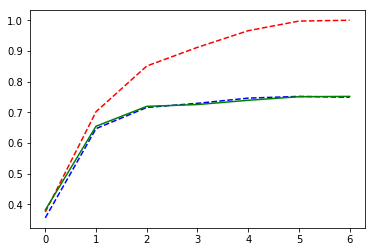

#############STOP################


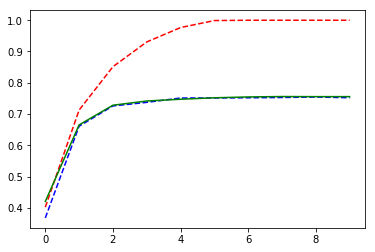

#############STOP################


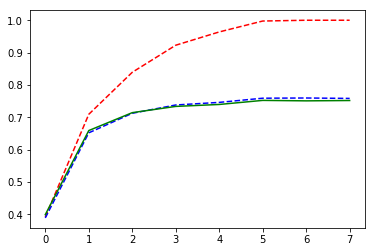

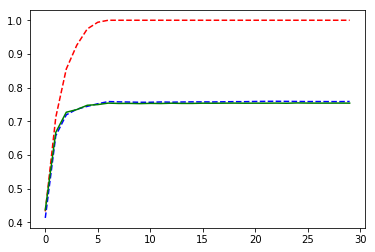

#############STOP################


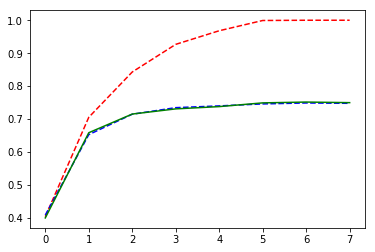

0.753213598309


In [28]:
chosen_opt = tf.train.GradientDescentOptimizer
chosen_rate = 0.05
chosen_activation = tf.nn.relu

layers = np.full(2,100)
layers = np.append(layers,26)
with tf.Session() as sess:
    print(try_on_test(Train_Classifier(x,layers,chosen_activation) ,chosen_opt,chosen_rate))